# GridLAB-D Geodata Subcommand Tutorial

As of version 4.2.21, HiPAS GridLAB-D supports the handling of geographic data.  This document provides a tutorial for using the `geodata` subcommand in GridLAB-D.

## System Preparation
The following command checks that the version of GridLAB-D supports the `geodata` subcommand.

In [1]:
!gridlabd --version='-ge 4.2.26'
!gridlabd requirements


Usage:   
  /usr/local/opt/python@3.9/bin/python3.9 -m pip <command> [options]

no such option: -r


# General Usage
The `geodata` subcommand uses the general syntax `gridlabd geodata OPTIONS DIRECTIVE [ARGUMENTS]`.  

## Creating location data

There are two basic types of geodata entities in GridLAB-D: 

1. an unordered collection of points each specified by a `latitude,longitude` tuple; and 

1. an ordered series of waypoints along a path specified by a sequence of `latitude,longitude` tuples.  

The interpretation of an entity is left to the dataset processor, but it can be specified using the `location` or `position` keys, for unordered and ordered geodata entities, respectively.  A geodata entity can be converted from one to another by simply changing the key (see **Geodata Indexing** below).

The `create` directive is used to create a new geodata entity.  The general syntax is `gridlabd geodata create LOCATIONS ...`.

There are two methods of introducing locations.  The first method introduces one or more `latitude,longitude` tuples directly in the command line.  For example, the following command creates a geodata entity with the approximate location of SLAC's main gate.

In [2]:
!gridlabd geodata create 37.415,-122.20

id,latitude,longitude
0,37.415,-122.2


Multiple locations can be introduced by adding them to the command line, for example:

In [3]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.21

id,latitude,longitude
0,37.41,-122.2
1,37.42,-122.21


The second method uses an input file with locations and associated data, such as this example CSV file:

In [4]:
!head -n 4 path_example.csv

latitude,longitude,configuration,pole_height
37.415045141688054,-122.2056472090359,flat3,18.0
37.414698020593065,-122.20848749028133,sideT,20.0
37.414454093051745,-122.21044282065421,sideT,21.0


To use this file, the following command can be used:

In [5]:
!gridlabd geodata create path_example.csv | head -n 4

id,latitude,longitude,configuration,pole_height
0,37.41505,-122.20565,flat3,18.0
1,37.4147,-122.20849,sideT,20.0
2,37.41445,-122.21044,sideT,21.0


Note that if multiple locations are provided they are sequenced in the order in which they are presented, including if locations are provided directly on the command line or from data files.

If no location information is given, then the geodata is read from `/dev/stdin`, e.g.,

In [6]:
!head -n 4 path_example.csv | cut -f1-2 -d, | gridlabd geodata create

id,latitude,longitude
0,37.41505,-122.20565
1,37.4147,-122.20849
2,37.41445,-122.21044


Additional fields can be added using an expanded command-line syntax, e.g.,

In [7]:
!gridlabd geodata create name=obj1+latitude=37.4205+longitude=-122.2046 name=obj2+latitude=37.5205+longitude=-122.3046

id,name,latitude,longitude
0,obj1,37.4205,-122.2046
1,obj2,37.5205,-122.3046


The default input delimiter is the `+` character.  This can be changed using the `--input_delimiter=STRING` option, e.g.,

In [8]:
!gridlabd geodata create --input_delimiter=',' 'name=obj1,latitude=37.4205,longitude=-122.2046' 'name=obj2,latitude=37.5205,longitude=-122.3046'

id,name,latitude,longitude
0,obj1,37.4205,-122.2046
1,obj2,37.5205,-122.3046


Note that the input delimiter must be set *before* it is used, and thus it can be changed as command line data is presented.

**Caveat**: The input delimiter can affect how strings are interpreted.  One common problem is setting the input delimiter to any character that is typically found in an address and then attempting to reverse resolve the address using the `address` dataset.  This can result in corrupted addresses being used.

## Some useful options

The default precision with which latitudes and longitudes are output is 5 decimals, which is approximately 1 meter resolution. You can change the precision with which latitudes and longitudes are output using the `-p` or `--precision` option, e.g.,

In [9]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -p 4

id,latitude,longitude
0,37.41,-122.2
1,37.42,-122.2
2,37.42,-122.21


This option actually changes the `precision.geolocation` option, which can also be set using the direct option set syntax, e.g.,

In [10]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 --precision.geolocation=4

id,latitude,longitude
0,37.41,-122.2
1,37.42,-122.2
2,37.42,-122.21


The default field separator for RAW output is a space. You can change this to any string using the `--fieldsep STRING` option, e.g.,

In [11]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f RAW --fieldsep ','

37.41,-122.2
37.42,-122.2
37.42,-122.21


This is equivalent to directly setting the field separator option using `--field_separator=','`.

Similarly the default record separator for RAW output is a newline. You can change this to any string using the `--recordsep STRING` option, e.g.,

In [12]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f RAW --fieldsep ',' --recordsep ';'

37.41,-122.2;37.42,-122.2;37.42,-122.21


This is equivalent to directly setting the record separator option using `--record_separator=';'`.

## Configurations
There are three locations where configuration settings are maintained: (1) the system shared folder, (2) the user's home folder, and (3) the local folder.  These are consulted in this order so that the system configuration overrides the default configuration, the user configuration override the system, and the local configuration overrides the user configuration.  

By default the configuration files are named `geodata.conf`.  The system configuration is stored in `$GLD_ETC/geodata/geodata.conf` folder.  The user configuration is stored in `$HOME/.gridlabd/geodata/geodata.conf` and the local configuration is stored in `$PWD/geodata.conf`. 

Any additional configuration file name can be consulted using the `-C FILENAME` or `--configfile FILENAME` option.

You can manage the current configuration using the `config` directive, e.g., to set the local configuration parameter `name` to `value`, use the `set` option

In [13]:
!gridlabd geodata config set name local_value -w

Note that if the file in which the parameter is stored does not already exist, you will get a warning before it is created. This behavior can be suppressed using the `-w` or `--warn` option, e.g.,

In [14]:
!gridlabd geodata config set name local_value -w

To get the value, use the `get` option:

In [15]:
!gridlabd geodata config get name

local_value


To show all the configuration values, use the `show` option:

In [16]:
!gridlabd geodata config show

geodata_url='http://geodata.gridlabd.us/'
output_format='CSV'
path_join='outer'
column_names='{'ID': 'id', 'UUID': 'uuid', 'LAT': 'latitude', 'LON': 'longitude', 'DIST': 'distance', 'HEAD': 'heading', 'LOC': 'location', 'POS': 'position'}'
uuid_type='4'
vegetation.username='name@example.com'
vegetation.password='password5839'
name='local_value'


To set a user configuration, use the `user.` prefix, e.g.,

In [17]:
!gridlabd geodata config set user.name user_value
!gridlabd geodata config show

geodata_url='http://geodata.gridlabd.us/'
output_format='CSV'
path_join='outer'
column_names='{'ID': 'id', 'UUID': 'uuid', 'LAT': 'latitude', 'LON': 'longitude', 'DIST': 'distance', 'HEAD': 'heading', 'LOC': 'location', 'POS': 'position'}'
uuid_type='4'
vegetation.username='name@example.com'
vegetation.password='password5839'
name='local_value'
user.name='user_value'


The same syntax is used for system configuration values, e.g.,

In [18]:
!gridlabd geodata config set system.name system_value
!gridlabd geodata config show

geodata_url='http://geodata.gridlabd.us/'
output_format='CSV'
path_join='outer'
column_names='{'ID': 'id', 'UUID': 'uuid', 'LAT': 'latitude', 'LON': 'longitude', 'DIST': 'distance', 'HEAD': 'heading', 'LOC': 'location', 'POS': 'position'}'
uuid_type='4'
vegetation.username='name@example.com'
vegetation.password='password5839'
name='local_value'
user.name='user_value'
system.name='system_value'


To remove a value, use the `unset` option, e.g.,

In [19]:
!gridlabd geodata config unset name
!gridlabd geodata config show

geodata_url='http://geodata.gridlabd.us/'
output_format='CSV'
path_join='outer'
column_names='{'ID': 'id', 'UUID': 'uuid', 'LAT': 'latitude', 'LON': 'longitude', 'DIST': 'distance', 'HEAD': 'heading', 'LOC': 'location', 'POS': 'position'}'
uuid_type='4'
vegetation.username='name@example.com'
vegetation.password='password5839'
user.name='user_value'
system.name='system_value'


To remove all the local configuration values, simply delete the `geodata.conf` file:

In [20]:
!rm geodata.conf

## Geodata formatting

The output format can be changed using the `-f` or `--format` option. The valid formats are `CSV`, `JSON`, `RAW`, `POS`, `GLM`, `FIELD`, `PLOT`, `GDF`, `XLSX`, and `TABLE`.  `CSV` format is the default, and it can be explicitly specified as follows:

In [21]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f CSV

id,latitude,longitude
0,37.41,-122.2
1,37.42,-122.2
2,37.42,-122.21


JSON output looks like this:

In [22]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f JSON

{"0":{"latitude":37.41,"longitude":-122.2},"1":{"latitude":37.42,"longitude":-122.2},"2":{"latitude":37.42,"longitude":-122.21}}


JSON output can be structured using the `pandas` `to_json()` `orient` options `index`, `split`, `records`, `columns`, `values`, or `table`, e.g.,

In [23]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f JSON --json.orient=table

{"schema":{"fields":[{"name":"id","type":"integer"},{"name":"latitude","type":"number"},{"name":"longitude","type":"number"}],"primaryKey":["id"],"pandas_version":"0.20.0"},"data":[{"id":0,"latitude":37.41,"longitude":-122.2},{"id":1,"latitude":37.42,"longitude":-122.2},{"id":2,"latitude":37.42,"longitude":-122.21}]}


Other JSON options include `data_format`, `double_precision`, `force_ascii`, and `date_unit`. See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_json.html for details.

RAW output is generated as follows

In [24]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f RAW

37.41 -122.2
37.42 -122.2
37.42 -122.21


TABLE output is generated for easy reading:

In [25]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f TABLE

    latitude  longitude
id                     
0      37.41    -122.20
1      37.42    -122.20
2      37.42    -122.21


Output formats typically can include an ordered field list, such as

In [26]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f RAW:longitude,latitude --fieldsep ,

-122.2,37.41
-122.2,37.42
-122.21,37.42


## Geodata indexing

The output can be indexed using one of several standards keys, or keys from the data. The default key is `id` which is the row number, as seen in the examples so far. This key can be explicitly specified as follows:

In [27]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -k id

id,latitude,longitude
0,37.41,-122.2
1,37.42,-122.2
2,37.42,-122.21


The `location` key generates a geohash code:

In [28]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -k location

location,latitude,longitude,id
9q9hg629j97y,37.41,-122.2,0
9q9hgk0em9ef,37.42,-122.2,1
9q9hgh17k9e4,37.42,-122.21,2


The `position` key generates a distance index, treating the data rows as a series of waypoints along a path. When this key is used, a distance and a heading column are also generated.

In [29]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -k position

position,latitude,longitude,id,distance,heading
0,37.41,-122.2,0,0.0,
1112,37.42,-122.2,1,1112.0,0.0
1995,37.42,-122.21,2,1995.0,270.0


Any field or set of fields may be used for indexing, e.g.,

In [30]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -k latitude,longitude

latitude,longitude,id
37.41,-122.2,0
37.42,-122.2,1
37.42,-122.21,2


Universally unique identifiers can be also be generated using the special `uuid` key, e.g.,

In [31]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -k uuid

uuid,latitude,longitude,id
814feaf2794e4dc08a25eddc4a68f043,37.41,-122.2,0
0f1c64584e604b2cac8c69eb40135b70,37.42,-122.2,1
adc8ba4186874fbb9a7ff18fe1b9eaad,37.42,-122.21,2


The default `uuid` type is a random number, i.e., `--uuid_type=4`.  Using `--uuid_type=1` generates a unique identified based on the host, sequence number, and time, e.g.,

In [32]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -k uuid --uuid_type=1

uuid,latitude,longitude,id
0705a628020d11ecbde8d0817adb129d,37.41,-122.2,0
0705a6e6020d11ecbde8d0817adb129d,37.42,-122.2,1
0705a718020d11ecbde8d0817adb129d,37.42,-122.21,2


## Path waypoints

Waypoints can be generated along a path using the `-r` or `--resolution` option.  For example, 250-meter waypoints are generated using the following syntax:

In [33]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -r 250 -f TABLE

          latitude  longitude   id  distance  heading
position                                             
0         37.41000 -122.20000  0.0       0.0      NaN
250       37.41225 -122.20000  NaN     250.0      0.0
500       37.41450 -122.20000  NaN     500.0      0.0
750       37.41674 -122.20000  NaN     750.0      0.0
1000      37.41899 -122.20000  NaN    1000.0      0.0
1112      37.42000 -122.20000  1.0    1112.0      0.0
1362      37.42000 -122.20283  NaN    1362.0    270.0
1612      37.42000 -122.20566  NaN    1612.0    270.0
1862      37.42000 -122.20849  NaN    1862.0    270.0
1995      37.42000 -122.21000  2.0    1995.0    270.0


This is equivalent to setting the `resolution` option value, e.g.,

In [34]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 --resolution=250 -f TABLE

          latitude  longitude   id  distance  heading
position                                             
0         37.41000 -122.20000  0.0       0.0      NaN
250       37.41225 -122.20000  NaN     250.0      0.0
500       37.41450 -122.20000  NaN     500.0      0.0
750       37.41674 -122.20000  NaN     750.0      0.0
1000      37.41899 -122.20000  NaN    1000.0      0.0
1112      37.42000 -122.20000  1.0    1112.0      0.0
1362      37.42000 -122.20283  NaN    1362.0    270.0
1612      37.42000 -122.20566  NaN    1612.0    270.0
1862      37.42000 -122.20849  NaN    1862.0    270.0
1995      37.42000 -122.21000  2.0    1995.0    270.0


The `distance` and `heading` columns are added to provide the distance and heading to each waypoint from the last position. When using waypoints, the key is automatically set to `position`, which provides the distance from the first point.  The use of other keys is not supported. In addition, any waypoint added in the process is not assigned a row `id` in order to protect the original row ids.

To assign key values to the generated positions, use `--resolution_id` options, e.g.,

In [35]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f TABLE -r 250  --resolution_id

          latitude  longitude     id  distance  heading
position                                               
0         37.41000 -122.20000  0.000       0.0      NaN
250       37.41225 -122.20000  0.125     250.0      0.0
500       37.41450 -122.20000  0.251     500.0      0.0
750       37.41674 -122.20000  0.376     750.0      0.0
1000      37.41899 -122.20000  0.501    1000.0      0.0
1112      37.42000 -122.20000  0.557    1112.0      0.0
1362      37.42000 -122.20283  0.683    1362.0    270.0
1612      37.42000 -122.20566  0.808    1612.0    270.0
1862      37.42000 -122.20849  0.933    1862.0    270.0
1995      37.42000 -122.21000  1.000    1995.0    270.0


The new id values are generated as a fraction of the distance from the first to the last waypoint.

The precision of the new id values can be changed, e.g.,

In [36]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f TABLE -r 250  --resolution_id --precision.resolution_id=5

          latitude  longitude       id  distance  heading
position                                                 
0         37.41000 -122.20000  0.00000       0.0      NaN
250       37.41225 -122.20000  0.12531     250.0      0.0
500       37.41450 -122.20000  0.25063     500.0      0.0
750       37.41674 -122.20000  0.37594     750.0      0.0
1000      37.41899 -122.20000  0.50125    1000.0      0.0
1112      37.42000 -122.20000  0.55739    1112.0      0.0
1362      37.42000 -122.20283  0.68271    1362.0    270.0
1612      37.42000 -122.20566  0.80802    1612.0    270.0
1862      37.42000 -122.20849  0.93333    1862.0    270.0
1995      37.42000 -122.21000  1.00000    1995.0    270.0


The index can be changed with the `-k` or `--key` options using a pipe. Sometimes this is necessary when one option used implicitly precludes the use of a desired key, such as when path resolution is used but location is indexing is desired, e.g.,

In [37]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -r 250 | gridlabd geodata create -k location -f TABLE

              position  latitude  longitude   id  distance  heading
location                                                           
9q9hg629j97y         0  37.41000 -122.20000  0.0       0.0      NaN
9q9hg68wjsgu       250  37.41225 -122.20000  NaN     250.0      0.0
9q9hg70em87c       500  37.41450 -122.20000  NaN     500.0      0.0
9q9hg788m9gu       750  37.41674 -122.20000  NaN     750.0      0.0
9q9hg7btmt7c      1000  37.41899 -122.20000  NaN    1000.0      0.0
9q9hgk0em9ef      1112  37.42000 -122.20000  1.0    1112.0      0.0
9q9hghne79td      1362  37.42000 -122.20283  NaN    1362.0    270.0
9q9hghhe39x6      1612  37.42000 -122.20566  NaN    1612.0    270.0
9q9hgh47rc94      1862  37.42000 -122.20849  NaN    1862.0    270.0
9q9hgh17k9e4      1995  37.42000 -122.21000  2.0    1995.0    270.0


## Output

By default all output is written to `/dev/stdout`.  The output can be written to a file using the `-o` or `--output` option, e.g.,

In [38]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -o /tmp/test.csv
!cat /tmp/test.csv

id,latitude,longitude
0,37.41,-122.2
1,37.42,-122.2
2,37.42,-122.21


GridLAB-D `geodata` entities can be output to GeoPandas using the `GDF` output format. If the entity does not include any geometry data, it is automatically created from the latitude and longitude fields, e.g.,

In [39]:
!gridlabd geodata create 37.410,-122.20 37.420,-122.20 37.420,-122.21 -o /tmp/test.gdf -f GDF

The following python code can be used to load the output file:

In [40]:
import geopandas
geopandas.read_file("/tmp/test.gdf")

,id,latitude,longitude,geometry
0,0,37.41,-122.20,POINT (-122.20000 37.41000)
1,1,37.42,-122.20,POINT (-122.20000 37.42000)
2,2,37.42,-122.21,POINT (-122.21000 37.42000)


----
# Datasets

The `merge` directive is used to merge a dataset into an existing `geodata` entity.  The general syntax is `gridlabd geodata merge -D DATASET [OPTIONS ...]`

## Distance

The `distance` dataset provide great-circle distance calculations.  For example, the following calculates the distance from the first point in the series.

In [41]:
!gridlabd geodata merge -D distance 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f TABLE

    latitude  longitude  distance
id                               
0      37.41    -122.20       0.0
1      37.42    -122.20    1112.0
2      37.42    -122.21    1995.0


The distance can be calculated relative to the previous location in the series using the `--relative` options, e.g.,

In [42]:
!gridlabd geodata merge -D distance 37.410,-122.20 37.420,-122.20 37.420,-122.21 --relative -f TABLE

    latitude  longitude  distance
id                               
0      37.41    -122.20       0.0
1      37.42    -122.20       0.0
2      37.42    -122.21       0.0


The `distance` dataset support different units, include `meters` or `m`, `kilometers` or `km`, `feet` or `ft`, `yards` or `yd`, `miles` or `mi`.  For example, the following calculates the distances in feet:

In [43]:
!gridlabd geodata merge -D distance 37.410,-122.20 37.420,-122.20 37.420,-122.21 --units=feet -f TABLE

    latitude  longitude  distance
id                               
0      37.41    -122.20       0.0
1      37.42    -122.20    3648.0
2      37.42    -122.21    6545.0


Note that the default precision with which distances are calculated in 0 decimals. Thus the distance in `km` is rounded:

In [44]:
!gridlabd geodata merge -D distance 37.410,-122.20 37.420,-122.20 37.420,-122.21 --units=km -f TABLE # precision too low

    latitude  longitude  distance
id                               
0      37.41    -122.20       0.0
1      37.42    -122.20       1.0
2      37.42    -122.21       2.0


The precision can be changed when necessary, e.g., 

In [45]:
!gridlabd geodata merge -D distance 37.410,-122.20 37.420,-122.20 37.420,-122.21 --units=km --precision.distance=2 -f TABLE

    latitude  longitude  distance
id                               
0      37.41    -122.20      0.00
1      37.42    -122.20      1.11
2      37.42    -122.21      2.00


When `distance` is used with `--resolution` and `--relative`, the waypoints are not considered, e.g.,

In [46]:
!gridlabd geodata -D distance merge 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f TABLE --table.max_rows=99 -r 250 --relative

          latitude  longitude   id  distance  heading
position                                             
0         37.41000 -122.20000  0.0       0.0      NaN
250       37.41225 -122.20000  NaN     250.0      0.0
500       37.41450 -122.20000  NaN     500.0      0.0
750       37.41674 -122.20000  NaN     750.0      0.0
1000      37.41899 -122.20000  NaN    1000.0      0.0
1112      37.42000 -122.20000  1.0       0.0      0.0
1362      37.42000 -122.20283  NaN     250.0    270.0
1612      37.42000 -122.20566  NaN     500.0    270.0
1862      37.42000 -122.20849  NaN     750.0    270.0
1995      37.42000 -122.21000  2.0       0.0    270.0


## Address

You can use the `address` dataset to perform address resolution operations, both to and from latitude and longitude.

To obtain the address at a location, use the following command

In [47]:
!gridlabd geodata merge -D address 37.420,-122.20

id,latitude,longitude,address
0,37.42,-122.2,"Stanford Linear Accelerator Center National Accelerator Laboratory, Sand Hill Road, Menlo Park, San Mateo County, California, 94028, United States"


To find the latitude and longitude of an address, use the command:

In [48]:
!gridlabd geodata merge -D address --reverse "2575 Sand Hill Rd, Menlo Park CA 94025"

id,index,address,longitude,latitude
0,0,"2575 Sand Hill Rd, Menlo Park CA 94025",-122.20457,37.42046


Note that incomplete addresses are usually resolved but may not provided the expected result.  For example, the following address is not sufficient for proper resolution, but provides a location nonetheless:

In [49]:
!gridlabd geodata merge -D address --reverse "Main St." # insufficient information for accurate results

id,index,address,longitude,latitude
0,0,Main St.,114.04407,22.31315


You can perform both operations in series to resolve the "official" address from an unofficial but complete address:

In [50]:
!gridlabd geodata merge -D address --reverse "2575 Sand Hill Rd, Menlo Park CA" | gridlabd geodata merge -D address

id,index,address,longitude,latitude
0,0,"54 - Stanford Research Computing Facility, 2575, Sand Hill Road, Stanford Hills, Menlo Park, San Mateo County, California, 94305, United States",-122.20118,37.41546


## Elevation
Elevation data can be obtained using the `elevation` data set, e.g.,  

In [51]:
!gridlabd geodata merge -D elevation 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f TABLE

    latitude  longitude  elevation
id                                
0      37.41    -122.20       58.0
1      37.42    -122.20       76.0
2      37.42    -122.21      105.0


Elevations can be calculated in other units using the `--units=UNIT` options, e.g.,

In [52]:
!gridlabd geodata merge -D elevation 37.410,-122.20 37.420,-122.20 37.420,-122.21 --units=feet -f TABLE

    latitude  longitude  elevation
id                                
0      37.41    -122.20      190.0
1      37.42    -122.20      249.0
2      37.42    -122.21      344.0


Valid units are `m` or `meters`, and `ft` or `feet`.

The precision of the elevations can be specified as well, e.g.,

In [53]:
!gridlabd geodata merge -D elevation 37.410,-122.20 37.420,-122.20 37.420,-122.21 --precision.elevation=2 --units=feet -f TABLE

    latitude  longitude  elevation
id                                
0      37.41    -122.20     190.29
1      37.42    -122.20     249.34
2      37.42    -122.21     344.49


When using waypoints, the elevations are calculated along the path, e.g.,

In [54]:
!gridlabd geodata merge -D elevation 37.410,-122.20 37.420,-122.20 37.420,-122.21 -r 250 -f TABLE

          latitude  longitude   id  distance  heading  elevation
position                                                        
0         37.41000 -122.20000  0.0       0.0      NaN       58.0
250       37.41225 -122.20000  NaN     250.0      0.0       63.0
500       37.41450 -122.20000  NaN     500.0      0.0       75.0
750       37.41674 -122.20000  NaN     750.0      0.0       76.0
1000      37.41899 -122.20000  NaN    1000.0      0.0       96.0
1112      37.42000 -122.20000  1.0    1112.0      0.0       76.0
1362      37.42000 -122.20283  NaN    1362.0    270.0       85.0
1612      37.42000 -122.20566  NaN    1612.0    270.0       92.0
1862      37.42000 -122.20849  NaN    1862.0    270.0      104.0
1995      37.42000 -122.21000  2.0    1995.0    270.0      105.0


## Vegetation
Vegetation data can be obtained using the `vegetation` dataset. This dataset includes information from the California Forest Observatory about canopy cover, height, and base.  To access this data you must subscribe to the service at https://forestobservatory.com. To register you username and password, you must configure the dataset using the following command:

In [55]:
!gridlabd geodata config set -w vegetation.username name@example.com
!gridlabd geodata config set vegetation.password password5839

When you are registered you can merge vegetation data for geographic locations, e.g.,

In [56]:
!gridlabd geodata merge -D vegetation 37.410,-122.20 37.420,-122.20 37.420,-122.21 -f TABLE --vegetation.usecache=False

    latitude  longitude  base  cover  height
id                                          
0      37.41    -122.20   2.0   0.17    11.0
1      37.42    -122.20   1.0   0.18    15.0
2      37.42    -122.21   2.0   0.01     0.0


Vegetation data is always associated with a year, which is specified by the `year` option, i.e.,

In [57]:
!gridlabd geodata merge -D vegetation 37.410,-122.20 37.420,-122.20 37.420,-122.21 --year=2020 -f TABLE

    latitude  longitude  base  cover  height
id                                          
0      37.41    -122.20   2.0   0.17    11.0
1      37.42    -122.20   1.0   0.18    15.0
2      37.42    -122.21   2.0   0.01     0.0


## Utility

Utility data can be obtained using the `utility` dataset.  This dataset includes information from the Homeland Infrastructure Foundation-Level Data (HIFLD).  Note that this dataset uses a very large datafile that can take some time to download the first time.

The name of the utility at a location is the default data result, e.g.,

In [58]:
!gridlabd geodata merge -D utility 37.420,-122.20 -f TABLE

    latitude  longitude             NAME
id                                      
0      37.42     -122.2  PACIFIC GAS ...


Other data is available (see https://hifld-geoplatform.opendata.arcgis.com/datasets/electric-retail-service-territories for detail).  A list of data available can be obtained from the dataset help, e.g., using `gridlabd geodata help utility`.  

To get the utility's summer and winter peak load and number of customers and the year for which the data is obtained, use the command

In [59]:
!gridlabd geodata merge -D utility 37.420,-122.20 --fields=WINTR_PEAK,SUMMR_PEAK,CUSTOMERS,YEAR -f TABLE

    latitude  longitude  WINTR_PEAK  SUMMR_PEAK  CUSTOMERS    YEAR
id                                                                
0      37.42     -122.2     12624.0     17263.0  5471786.0  2018.0


The `utility` dataset also contains geometry data that can be used to generate maps. This data is included when the `--geometry` option is specified, e.g.,

In [60]:
!gridlabd geodata merge -D utility 37.420,-122.20 --geometry -f PLOT -o /tmp/utility.png --plot.figsize=10,5

The following python code can be used to display the image in a Jupyter notebook.

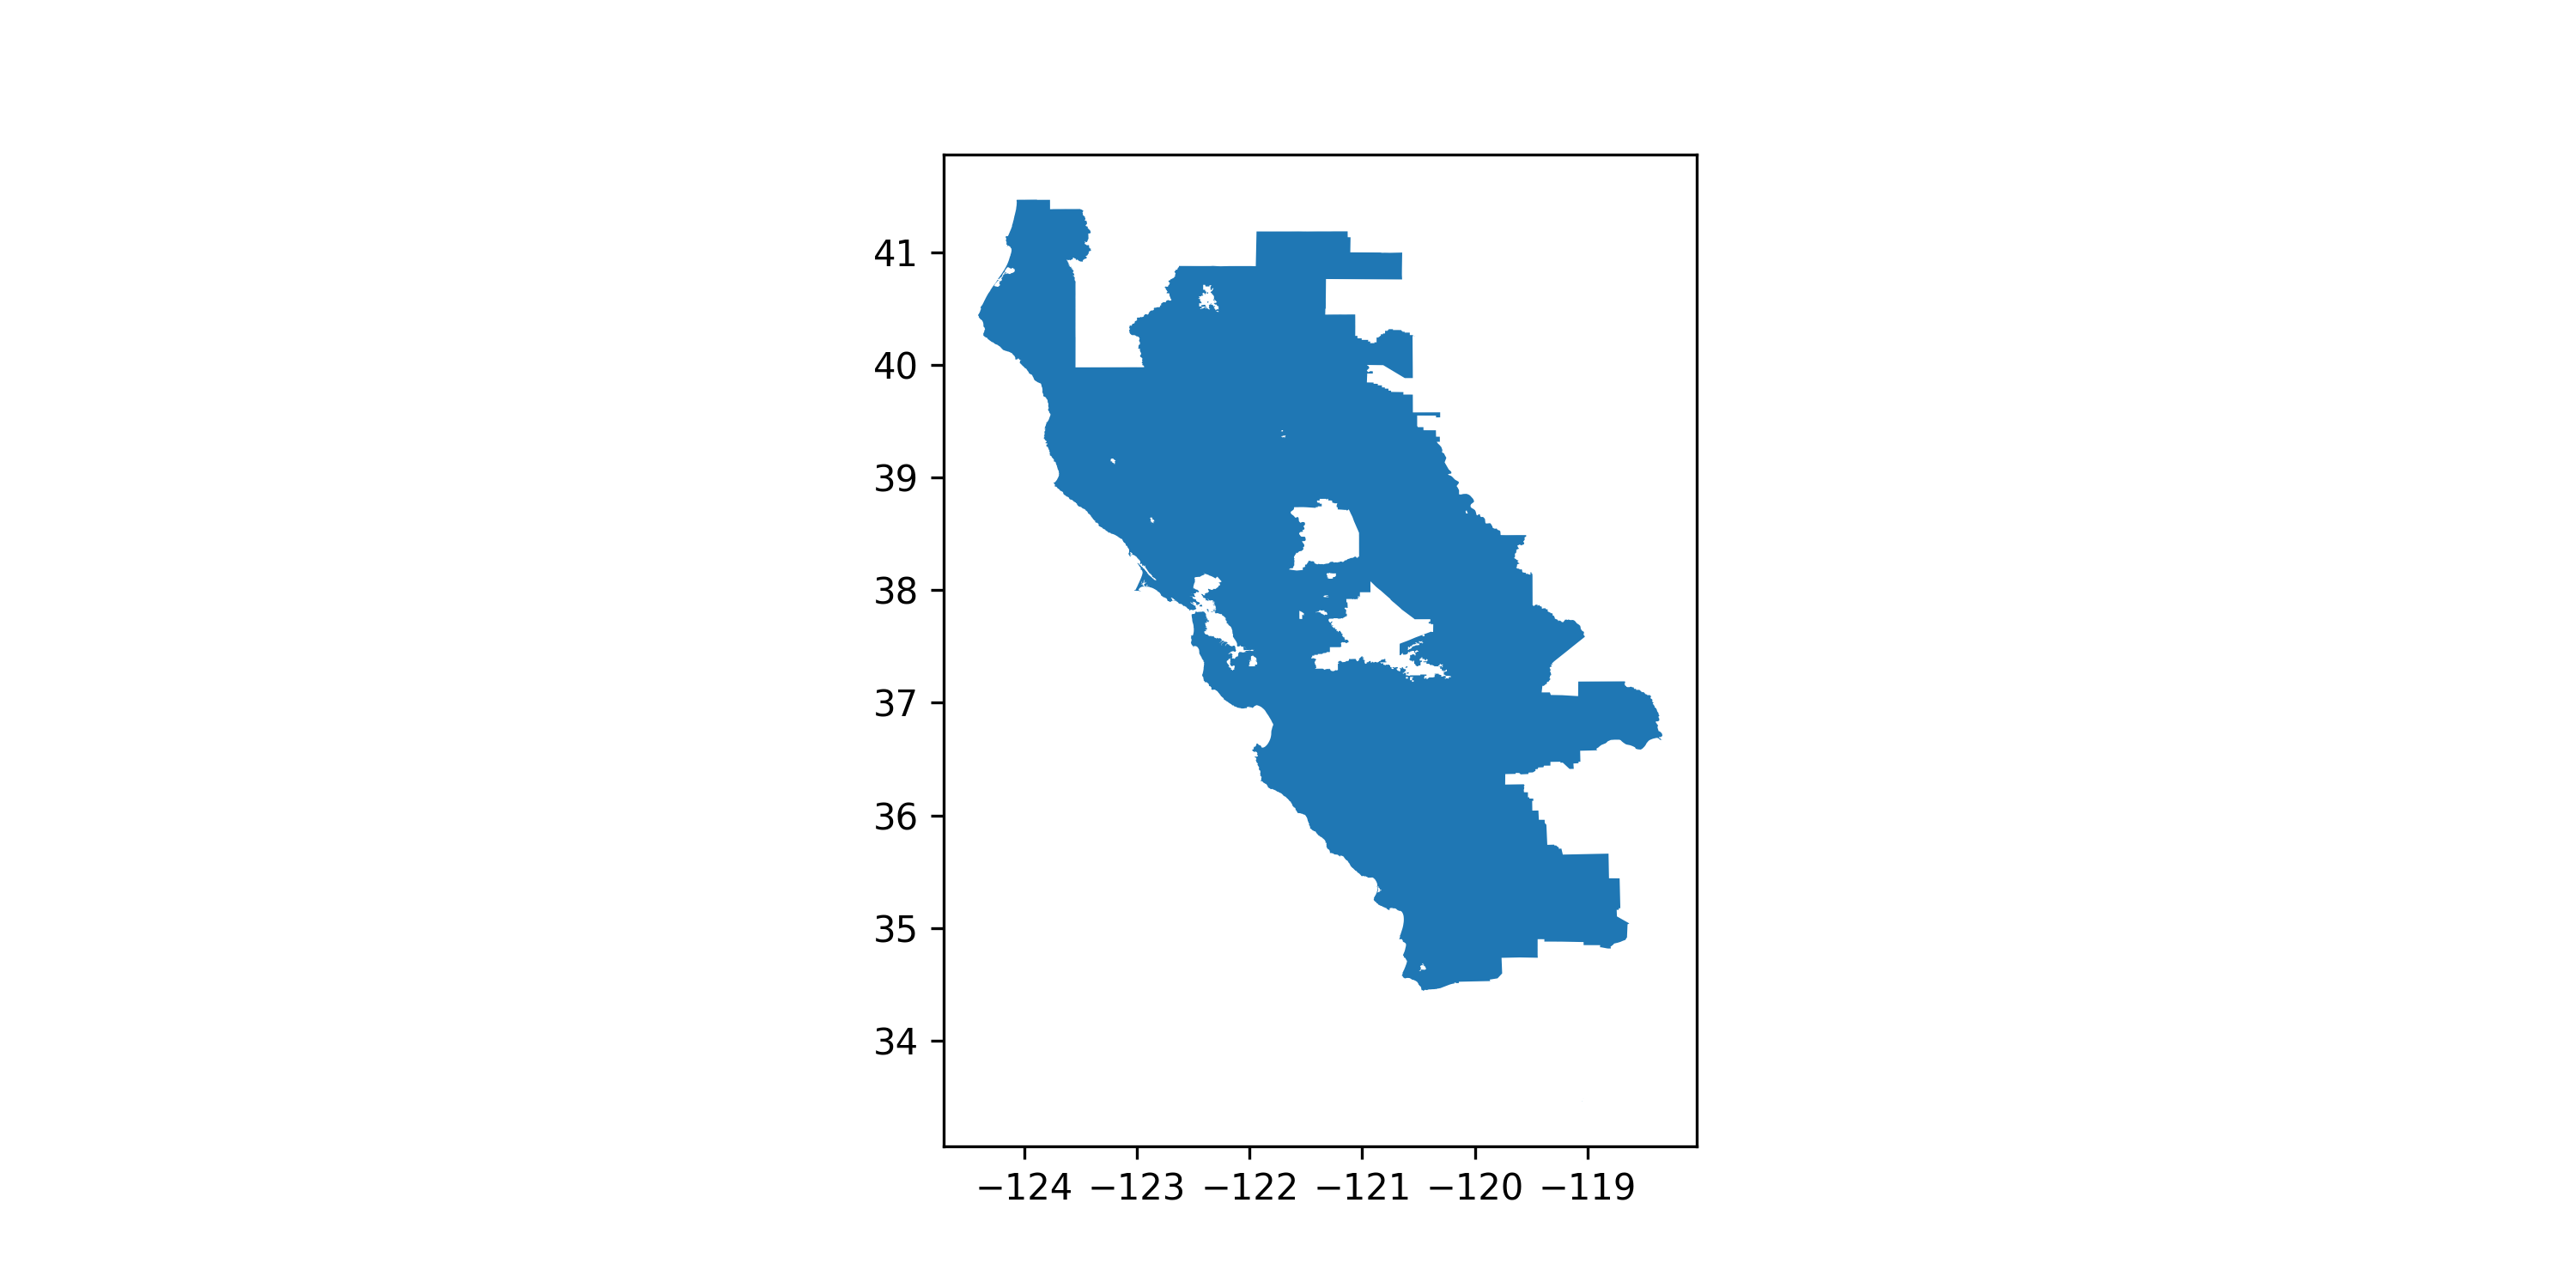

In [61]:
from IPython.display import Image
Image("/tmp/utility.png")

## Powerline

Powerline calculations can be performed using the `powerline` dataset.  This dataset calculates line sag, line sway, and line gallop.  

To use this dataset additional data is usually required. When the needed data is not available at a specific position or location, static values can be provided using the available dataset options. Valid dataset options include the following:

- `--air_temperature=FLOAT` specified in Celsius, with a default of 30 C.
- `--wind_speed=FLOAT` specified in m/s, with a default is 0 m/s.
- `--wind_direction=FLOAT` specified in degrees, with a default is 0 degrees.
- `--ice_thickness=FLOAT` specified in meters, with a default is 0 m.
- `--power_flow=FLOAT` specified in Watts, with a default is 0 W.
- `--global_horizontal_irradiance=FLOAT` specified in W/m^2, with a default of 1000 W/m^2.
- `--ground_reflectance=FLOAT` specified per unit, with a default of 0.3 pu.
- `--ice_density=FLOAT` specified in kg/m^3, with a default of 915 kg/m^3.
- `--nominal_temperature=FLOAT` specified in Celcius, with a default of 15 C.
- `--cable_type=STRING` specified as a string lookup in the cable type file, with no default value.
- `--elevation=FLOAT` specified in m above sea level, with a default of 0 m.

For example, the cable type has no default and a reference to a known cable type can be given on the command line, e.g.,

In [62]:
!gridlabd geodata merge -D powerline path_example.csv --cable_type="TACSR/AC 610mm^2" -r 50 -f TABLE:linesag

WARNING [geodata/powerline]: cannot run function CONTACT and 'height' is missing or invalid
          linesag
position         
0            18.0
50           12.2
100           9.4
150           9.7
200          13.0
...           ...
8390        -16.6
8440         -8.9
8490          0.6
8540         12.0
8583         23.0

[191 rows x 1 columns]


Known cable types are listed in the `geodata_powerline_cabletypes.csv`, which contains the following fields:

In [63]:
import pandas
print("\n".join(pandas.read_csv("../geodata_powerline_cabletypes.csv").columns.to_list()))

id
diameter
unit_weight
rated_tensile_strength
elasticity
thermal_expansion
conductor_crosssection_area
resistivity
nominal_resistance
nomimal_temperature
voltage_rating
reflectivity
emissivity


The first record contains the following values

In [64]:
pandas.read_csv("../geodata_powerline_cabletypes.csv",nrows=1).transpose()

,0
id,TACSR/AC 610mm^2
diameter,0.0342
unit_weight,21.56
rated_tensile_strength,72000
elasticity,7.18e+10
thermal_expansion,2.06e-05
conductor_crosssection_area,0.0006918
resistivity,0.0039
nominal_resistance,4.58e-05
nomimal_temperature,15


When needed data is not provided or the value provided is invalid, a warning is output and the requested values are not calculated, e.g.,

In [65]:
!gridlabd geodata merge -D powerline path_example.csv -f TABLE:linesag # missing cable type

WARNING [geodata/powerline]: cable_type not specified
WARNING [geodata/powerline]: cannot run function CONTACT and 'height' is missing or invalid
    linesag
id         
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
..      ...
32      NaN
33      NaN
34      NaN
35      NaN
36      NaN

[37 rows x 1 columns]


In [66]:
!gridlabd geodata merge -D powerline path_example.csv -f TABLE:linesag --cable_type="My cabletype" # bad cable type

WARNING [geodata/powerline]: cable_type='My cabletype' not found
WARNING [geodata/powerline]: cannot run function CONTACT and 'height' is missing or invalid
    linesag
id         
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
..      ...
32      NaN
33      NaN
34      NaN
35      NaN
36      NaN

[37 rows x 1 columns]


---
# Getting help

You can obtain help using the `help` directive, e.g.,

In [67]:
!gridlabd geodata help | head -n 10

Help on module __main__:

NAME
    __main__ - Syntax: gridlabd geodata OPTIONS DIRECTIVE [ARGUMENTS]

DESCRIPTION
    The geodata command gathers and joins geographic data. The geodata subcommand
    uses directives that are documented in the DIRECTIVES section below.
    
    In general geodata is used to acquire geographic information at a location or


In [68]:
!gridlabd geodata help distance | head -n 10

Help on module geodata_distance:

NAME
    geodata_distance - GridLAB-D Geodata Distance Package

DESCRIPTION
    The distance package computes the shortest distance between consecutive
    positions.
    
    OPTIONS


---
# Output Options

## Verbose

The `-v` or `--verbose` option can be used to get additional output about the stages of processing, e.g., 

In [69]:
!gridlabd geodata merge -D distance 37,-122 38,-122 -v --units=km --precision.distance=3

VERBOSE [geodata/distance]: verbose output enabled
VERBOSE [geodata/distance]: arg=37,-122 --> append 1 rows from args
VERBOSE [geodata/distance]: arg=38,-122 --> append 1 rows from args
VERBOSE [geodata/distance]: arg=--units=km --> option ['units', 'km'] accepted
VERBOSE [geodata/distance]: arg=--precision.distance=3 --> option ['precision.distance', '3'] accepted
VERBOSE [geodata/distance]: 2 rows total received
VERBOSE [geodata/distance]: creating row index
VERBOSE [geodata/distance]: data = 
--------------------------
   latitude  longitude  id
0      37.0     -122.0   0
1      38.0     -122.0   1
--------------------------

VERBOSE [geodata/distance]: options = {
    "verbose": true,
    "debug": false,
    "silent": false,
    "quiet": false,
    "warning": true,
    "key_index": "",
    "max_threads": 1,
    "config_file": "geodata.conf",
    "field_separator": " ",
    "record_separator": "\n",
    "input_delimiter": "+",
    "warning_as_error": false,
    "plot": {
        "f

## Silent

The `-s` or `--silent` option suppresses error messages while still returning an error condition, e.g.,

In [70]:
!gridlabd geodata merge -D distance 37,-122 38,-122 --badoption -s || echo "Exit code $?"

Exit code 4


## Warning

The `-w` or `--warning` option suppresses warning messages, e.g.,

In [71]:
!gridlabd geodata merge -D distance 37,-122 38,-122 -r 100 -k location -w -f TABLE

              latitude  longitude  id  distance
location                                       
9q94rzdk9gyt      37.0     -122.0   0       0.0
9qc0pvdq1cqt      38.0     -122.0   1  111195.0


If an error is desired instead of a warning, use the `--warning_as_error` option, e.g.,

In [72]:
!gridlabd geodata merge -D distance 37,-122 38,-122 -r 100 -k location --warning_as_error # key warning is an error

ERROR [geodata/distance]: using index 'location' cannot be used with '--resolution=100.0' option


## Debug

The `-d` or `--debug` option can be used to obtain details about why an error occurred.  For example, the following command has an invalid `lat,lon` tuple and results in a simple error message:

In [73]:
!gridlabd geodata merge -D distance 37,-122 38,-122 --units=furlongs

ERROR [geodata/distance]: unit 'furlongs' is not recognized


Using the debug option provides a more detailed traceback of the error that can be helpful in diagnostic the problem, particularly when it originates in a dataset package. The call arguments, options, and configuration is also output after the traceback information.

In [74]:
!gridlabd geodata merge -D distance 37,-122 38,-122 --units=furlongs -d # invalid unit

Traceback (most recent call last):
  File "/usr/local/opt/gridlabd/4.2.26-210820-develop_add_cyme_converter/bin/gridlabd-geodata", line 854, in merge
    result = MODULE.apply(data,options,config,warning)
  File "/usr/local/opt/gridlabd/4.2.26-210820-develop_add_cyme_converter/share/gridlabd/geodata_distance.py", line 119, in apply
    raise Exception(f"unit '{options['units']}' is not recognized")
Exception: unit 'furlongs' is not recognized
DEBUG [geodata/distance]: merge(args=['37,-122', '38,-122', '--units=furlongs']) --> data = 
----
None
----
options = {
    "verbose": false,
    "debug": true,
    "silent": false,
    "quiet": false,
    "warning": true,
    "key_index": "",
    "max_threads": 1,
    "config_file": "geodata.conf",
    "field_separator": " ",
    "record_separator": "\n",
    "input_delimiter": "+",
    "warning_as_error": false,
    "plot": {
        "figsize": [
            7.0,
            5.0
        ],
        "cmap": "",
        "categorical": false,
      

Note that using the debug flag also enables traceback of warnings from inside python modules, but may not traceback warnings from geodata packages. If this occurs, use the `--warning_as_error` option.

# Configurations versus Options

Configurations can be set in advance using configuration files and the `config` directive, or they can be specified at the command line.  Options can only be specified on the command line.

The current `geodata` configuration values are obtained using the `--show_config` command line option:

In [75]:
!gridlabd geodata --show_config

--geodata_url='http://geodata.gridlabd.us/'
--output_format='CSV'
--path_join='outer'
--column_names.ID='id'
--column_names.UUID='uuid'
--column_names.LAT='latitude'
--column_names.LON='longitude'
--column_names.DIST='distance'
--column_names.HEAD='heading'
--column_names.LOC='location'
--column_names.POS='position'
--uuid_type=4
--vegetation.username='name@example.com'
--vegetation.password='password5839'


This list will always include all the `system`, `user`, and `local` configuration items.

The valid `geodata` option values are obtained using a similar command for options, e.g.,

In [76]:
!gridlabd geodata --show_options

--verbose=False
--debug=False
--silent=False
--quiet=False
--warning=True
--key_index=''
--max_threads=1
--config_file='geodata.conf'
--field_separator=' '
--record_separator='\n'
--input_delimiter='+'
--warning_as_error=False
--plot.figsize=7.0.5.0
--plot.cmap=''
--plot.categorical=False
--plot.legend=False
--plot.scheme=''
--plot.k=5
--plot.vmin=nan
--plot.vmax=nan
--plot.aspect='auto'
--show.block=True
--savefig.dpi=300
--savefig.facecolor='w'
--savefig.edgecolor='k'
--savefig.orientation='landscape'
--savefig.format='png'
--savefig.transparent=False
--savefig.pad_inches=0.1
--table.max_rows=10
--table.max_columns=10
--table.width=80
--table.max_colwidth=16
--precision.distance=0
--precision.heading=1
--precision.geolocation=5
--precision.id=0
--precision.resolution_id=3
--resolution=0
--resolution_id=False
--json.orient='index'
--json.data_format='iso'
--json.double_precision=10
--json.force_ascii=True
--json.date_unit='s'
--filter=''
--select=''


----
# GridLAB-D Models

The `geodata` subcommand can be used from within GridLAB-D model files (GLM) files.  All GridLAB-D objects have a header attribute for latitude and longitude, and thus can provide the data needed to perform `geodata` create and merge operations.

The following step-by-step example illustrates how address resolution can be performed on a GLM object.

## Step 1: Add the needed geodata fields to the affected object classes

~~~
module residential;
class house
{
    char1024 address;
}
~~~

The `class` declaration adds the `address` field to the definition of `house` provided by the `residential` module.

## Step 2: Create the needed objects with the required data

~~~
object 
{
    address "2575 Sand Hill Rd., Menlo Park, CA, 94025";
}
~~~

## Step 3: Write the CSV data file needed to create the `geodata` entity

~~~
#write /tmp/house_address.csv house:address
~~~

The `#write` macro generates a CSV field of all the `house` objects with only the `address` fields, which looks like this:

~~~
id,class,name,address
0,house,"house:0","2575 Sand Hill Rd., Menlo Park, CA"
~~~

## Step 4: Run the desired `geodata` operation

~~~
#geodata merge -D address /tmp/house_address.csv --reverse --format GLM:@latitude,longitude -o /tmp/house_latlon.glm
~~~

The command merges the `address` dataset into the data from the CSV file, performing a reverse address resolution (i.e., address to location), and outputs the result to a GLM file.  The `GLM` format options specified only the `latitude` and `longitude` fields are to be generated.  The `@` symbol reformats the GLM output using `modify` directives instead of the default `object` directives. This is necessary to update existing objects rather than creating new ones.  The resulting file looks like this:

~~~
modify house:0.longitude "-122.20118";
modify house:0.latitude "37.41546";
~~~

## Step 5: Include the updated values

~~~
#include /tmp/house_latlon.glm
~~~

Now the object has the latitude and longitude data set based on the address provided.

## Example 1
The following example illustrates the result of using this method to resolve the geolocation of a house using its address.

In [77]:
!cat example.glm

module residential;
class house
{
    char1024 address;
}

object house
{
    name "Building_53";
    address "2575 Sand Hill Rd., Menlo Park, CA";
}
#write /tmp/address.csv house:address
#geodata merge -D address /tmp/address.csv --reverse --format GLM:@latitude,longitude -o /tmp/latlon.glm
#include "/tmp/latlon.glm"


In [78]:
!gridlabd -I -w example.glm -o /tmp/example.json
!gridlabd json-get objects Building_53 </tmp/example.json | awk '/latitude|longitude|address/{print$0;}'

    "latitude": "37.415460",
    "longitude": "-122.201180",
    "address": "2575 Sand Hill Rd., Menlo Park, CA",


# Example 2
The following example illustrates using pipes to chain merge commands. In this case, the elevation data is generated at 25 meter resolution along the path, and the result is passed to the distance calculation which fills in the relative distance from the points in the original dataset.

In [79]:
!gridlabd geodata merge -D elevation path_example.csv -r 250 \
| gridlabd geodata merge -D distance -f TABLE --relative --table.width=999 --table.max_rows=999

      position  latitude  longitude configuration  pole_height  distance  heading  elevation
id                                                                                          
0.0          0  37.41505 -122.20565         flat3         18.0       0.0      NaN       88.0
NaN        250  37.41471 -122.20845           NaN          NaN     250.0    263.0      100.0
1.0        254  37.41470 -122.20849         sideT         20.0       0.0    263.0      100.0
2.0        428  37.41445 -122.21044         sideT         21.0       0.0    262.7      111.0
3.0        595  37.41422 -122.21231         sideT         18.0       0.0    263.0      110.0
4.0        771  37.41398 -122.21427         sideT         20.0       0.0    263.0       98.0
5.0        976  37.41370 -122.21657         sideT         18.0       0.0    263.1       91.0
6.0       1128  37.41348 -122.21827         sideT         21.0       0.0    262.6       77.0
7.0       1326  37.41321 -122.22048         sideT         18.0       0

# Example 3
Ths following example illustrates merging elevation, vegetation, and powerline data.

In [80]:
!gridlabd geodata merge -D elevation path_example.csv -r 30 --resolution_id \
| gridlabd geodata merge -D vegetation -w | grep -v WARNING \
| gridlabd geodata merge -D powerline --cable_type="TACSR/AC 610mm^2" --margin.vertical=2 -f TABLE:latitude,longitude,pole_height,elevation,linesag,cover,height,contact --table.width=999 --table.max_rows=999

       latitude  longitude  pole_height  elevation  linesag  cover  height  contact
id                                                                                 
0.000  37.41505 -122.20565         18.0       88.0     18.0   0.68    14.0     0.00
0.003  37.41501 -122.20599          NaN       89.0     14.5   0.73    16.0     0.73
0.007  37.41497 -122.20632          NaN       89.0     13.2   0.74    16.0     0.74
0.010  37.41493 -122.20666          NaN       90.0     12.0   0.72    17.0     0.72
0.014  37.41488 -122.20699          NaN       91.0     11.8   0.56    17.0     0.56
0.017  37.41484 -122.20733          NaN       92.0     12.8   0.30    17.0     0.30
0.021  37.41480 -122.20766          NaN       93.0     14.8   0.14    16.0     0.14
0.024  37.41476 -122.20800          NaN       95.0     17.0   0.07    10.0     0.00
0.028  37.41472 -122.20834          NaN       98.0     19.3   0.09     1.0     0.00
0.030  37.41470 -122.20849         20.0      100.0     20.0   0.09     1.0  